<a href="https://colab.research.google.com/github/Pasindu-Madhuwantha/DL_ASSIGNMENT/blob/IT20609030/2.notebooks/DL_Stock_Market_Prediction_using_CNN_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import Libraries

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

Load Dataset

In [4]:
#Load the dataset from csv file
df = pd.read_csv('/content/sample_data/DATA.csv')
df.head()

,Date,Open,High,Low,Close,Volume,NASDAQ,NYSE,S&P 500,FTSE100,...,RUSSELL2000,HENG SENG,SSE,Crude Oil,Gold,VIX,USD index,Amazon,Google,Microsoft
0,2010/7/1,9.082143,9.100000,8.686429,8.874286,1022896000,2101.360107,6462.029785,1027.369995,4805.75,...,604.760010,NaN,2373.791992,72.949997,1206.300049,32.860001,84.72,110.959999,110.959999,23.160000
1,2010/7/2,8.946072,8.961785,8.685715,8.819285,693842800,2091.790039,6434.810059,1022.580017,4838.09,...,598.969971,19905.32031,2382.900879,72.139999,1207.400024,30.120001,84.43,109.139999,109.139999,23.270000
2,2010/7/6,8.964286,9.028571,8.791429,8.879642,615235600,2093.879883,6486.089844,1028.060059,4965.00,...,590.030029,20084.11914,2409.424072,71.980003,1194.800049,29.650000,84.08,110.059998,110.059998,23.820000
3,2010/7/7,8.946072,9.241786,8.919642,9.238214,654556000,2159.469971,6685.779785,1060.270020,5014.82,...,611.659973,19857.07031,2421.116943,74.070000,1198.599976,26.840000,83.82,113.430000,113.430000,24.299999
4,2010/7/8,9.374286,9.389286,9.103214,9.217500,738144400,2175.399902,6755.810059,1070.250000,5105.45,...,620.270020,20050.56055,2415.149902,75.440002,1195.800049,25.709999,83.82,116.220001,116.220001,24.410000


Data Preprocessing

In [5]:
# Rename the columns
df.columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'NASDAQ', 'NYSE', 'S&P 500', 'FTSE100',
              'NIKKI225', 'BSE SENSEX', 'RUSSELL2000', 'HENG SENG', 'SSE', 'Crude Oil', 'Gold', 'VIX',
              'USD index', 'Amazon', 'Google', 'Microsoft']

# Convert the 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Section 1: Data Cleaning - Remove Rows with NaN Values
df.dropna(inplace=True)

# Section 2: Data Preprocessing - Scale the Target Variable (e.g., 'Gold')
sc = MinMaxScaler(feature_range=(0, 1))
train_data_scaled = sc.fit_transform(df[['Gold']])  # Assuming 'Gold' is the target variable

# Set the number of timesteps
timesteps = 8

# Create data sets where each sample has 8 timesteps and 1 output
x_train = []
y_train = []

for i in range(timesteps, len(train_data_scaled)):
    x_train.append(train_data_scaled[i - timesteps:i, 0])
    y_train.append(train_data_scaled[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)

# Section 3: Choose Target Variable and Date Range
target = 'Gold'
train_start_date = pd.to_datetime(datetime.date(2010, 7, 1))
train_end_date = pd.to_datetime(datetime.date(2017, 1, 1))
test_start_date = train_end_date

# Section 4: Filter Data Based on Date Range
train_data = df[(df['Date'] >= train_start_date) & (df['Date'] <= train_end_date)]
test_data = df[df['Date'] >= test_start_date]

# Check for NaN values in the entire DataFrame
nan_count = df.isna().sum()

# Print the count of NaN values for each column
print(nan_count)

# Check if there are any NaN values in the entire DataFrame
if nan_count.sum() > 0:
    print("There are NaN values in the DataFrame.")
else:
    print("No NaN values found in the DataFrame.")


Date           0
Open           0
High           0
Low            0
Close          0
Volume         0
NASDAQ         0
NYSE           0
S&P 500        0
FTSE100        0
NIKKI225       0
BSE SENSEX     0
RUSSELL2000    0
HENG SENG      0
SSE            0
Crude Oil      0
Gold           0
VIX            0
USD index      0
Amazon         0
Google         0
Microsoft      0
dtype: int64
No NaN values found in the DataFrame.


In [17]:
# Convert train_end_date to a datetime object
train_end_date = pd.to_datetime(train_end_date)

# Manually split the data based on date
train_data = df[df['Date'] <= train_end_date]
test_data = df[df['Date'] > train_end_date]

# Use MinMaxScaler to scale the training_set
sc = MinMaxScaler(feature_range=(0, 1))
training_set_scaled = sc.fit_transform(train_data[['Gold']])  # Assuming 'Gold' is the target variable

# Set the number of timesteps
timesteps = 8

# Create data sets where each sample has 8 timesteps and 1 output
x_train = []
y_train = []

for i in range(timesteps, len(training_set_scaled)):
    x_train.append(training_set_scaled[i - timesteps:i, 0])
    y_train.append(training_set_scaled[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape input data
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))

# Print the first two samples
#print(x_train[0], y_train[0])
#print(x_train[1], y_train[1])

Create and Compile the Model

In [13]:
# For creating model and training
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout, Bidirectional, TimeDistributed
from tensorflow.keras.layers import MaxPooling1D, Flatten
from tensorflow.keras.regularizers import L1, L2
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.metrics import RootMeanSquaredError

In [21]:
# Create the Sequential model
model = keras.Sequential()

# CNN layer with MaxPooling
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(timesteps, 1)))
model.add(MaxPooling1D(pool_size=2))

# LSTM layer
model.add(LSTM(units=50, return_sequences=True))

# Flatten layer
model.add(Flatten())

# Dense output layer
model.add(Dense(units=1, activation='linear'))

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mse', 'mae'])

#Train the Model
model.fit(x_train, y_train, epochs=50, batch_size=32, verbose=1)


Epoch 1/50
42/42 [==============================] - 3s 6ms/step - loss: 0.0866 - mse: 0.0866 - mae: 0.2091
Epoch 2/50
42/42 [==============================] - 0s 5ms/step - loss: 0.0047 - mse: 0.0047 - mae: 0.0324
Epoch 3/50
42/42 [==============================] - 0s 5ms/step - loss: 0.0043 - mse: 0.0043 - mae: 0.0269
Epoch 4/50
42/42 [==============================] - 0s 6ms/step - loss: 0.0042 - mse: 0.0042 - mae: 0.0253
Epoch 5/50
42/42 [==============================] - 0s 6ms/step - loss: 0.0041 - mse: 0.0041 - mae: 0.0238
Epoch 6/50
42/42 [==============================] - 0s 6ms/step - loss: 0.0041 - mse: 0.0041 - mae: 0.0242
Epoch 7/50
42/42 [==============================] - 0s 6ms/step - loss: 0.0040 - mse: 0.0040 - mae: 0.0232
Epoch 8/50
42/42 [==============================] - 0s 6ms/step - loss: 0.0040 - mse: 0.0040 - mae: 0.0222
Epoch 9/50
42/42 [==============================] - 0s 6ms/step - loss: 0.0039 - mse: 0.0039 - mae: 0.0207
Epoch 10/50
42/42 [==================

Evaluate the Model

23/23 [==============================] - 1s 3ms/step
Mean Squared Error (MSE): 20118.47
Mean Absolute Error (MAE): 32.49
Root Mean Squared Error (RMSE): 141.84
Mean Squared Error (MSE): 20118.47
Mean Absolute Error (MAE): 32.49
R-squared (R2): 0.51


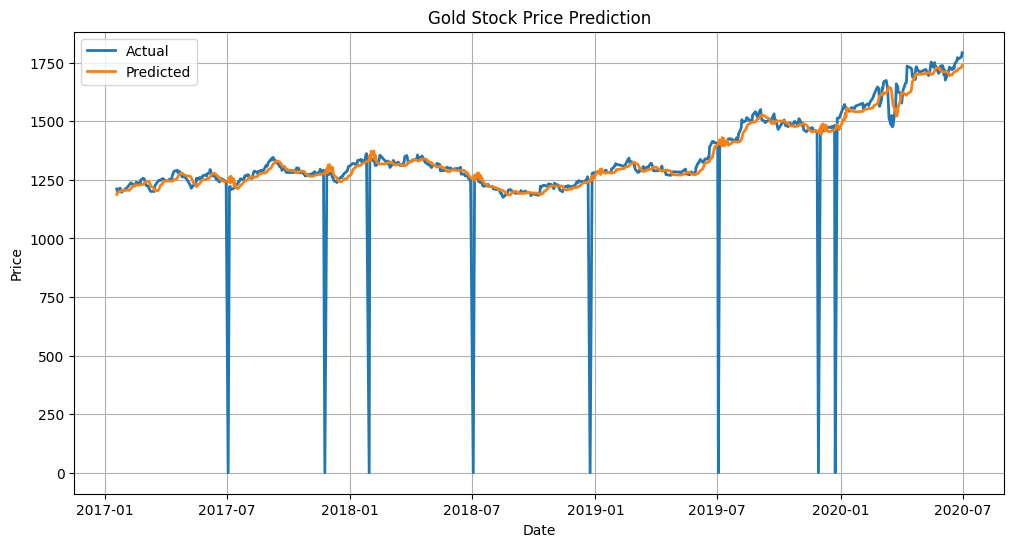

In [22]:
# Section 6: Evaluate Model (e.g., using mean_squared_error, mean_absolute_error, r2_score)

# Evaluate the model on test data
test_data_scaled = sc.transform(test_data[['Gold']])  # Scale test data

# Create sequences for test data
x_test = []
y_test = []

for i in range(timesteps, len(test_data_scaled)):
    x_test.append(test_data_scaled[i - timesteps:i, 0])
    y_test.append(test_data_scaled[i, 0])

x_test, y_test = np.array(x_test), np.array(y_test)

# Reshape input data
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

# Predict on test data
y_pred = model.predict(x_test)

# Inverse transform the predictions and actual values to the original scale
y_pred = sc.inverse_transform(y_pred)
y_test = sc.inverse_transform(y_test.reshape(-1, 1))


# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)

# Print evaluation metrics
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print evaluation metrics
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R-squared (R2): {r2:.2f}")

# Plot actual vs. predicted values
test_dates = test_data['Date'].iloc[timesteps:]  # Exclude the first timesteps dates
plt.figure(figsize=(12, 6))
plt.plot(test_dates, y_test, label='Actual', linewidth=2)
plt.plot(test_dates, y_pred, label='Predicted', linewidth=2)
plt.title('Gold Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()


65/65 [==============================] - 0s 2ms/step


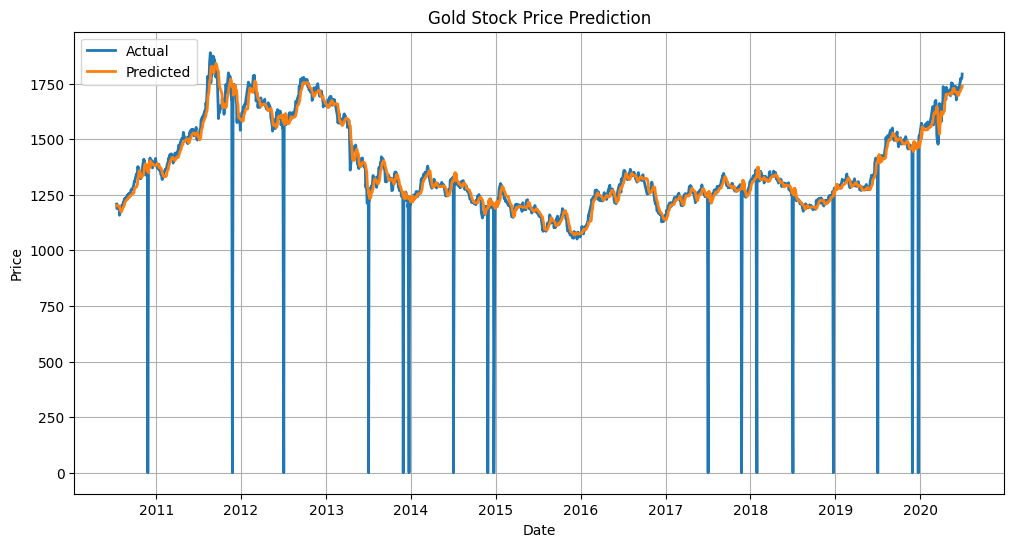

Mean Squared Error (MSE) for Gold: 15737.06
Mean Absolute Error (MAE) for Gold: 32.41
Root Mean Squared Error (RMSE) for Gold: 125.45
R-squared (R2) for Gold: 0.68
65/65 [==============================] - 0s 3ms/step


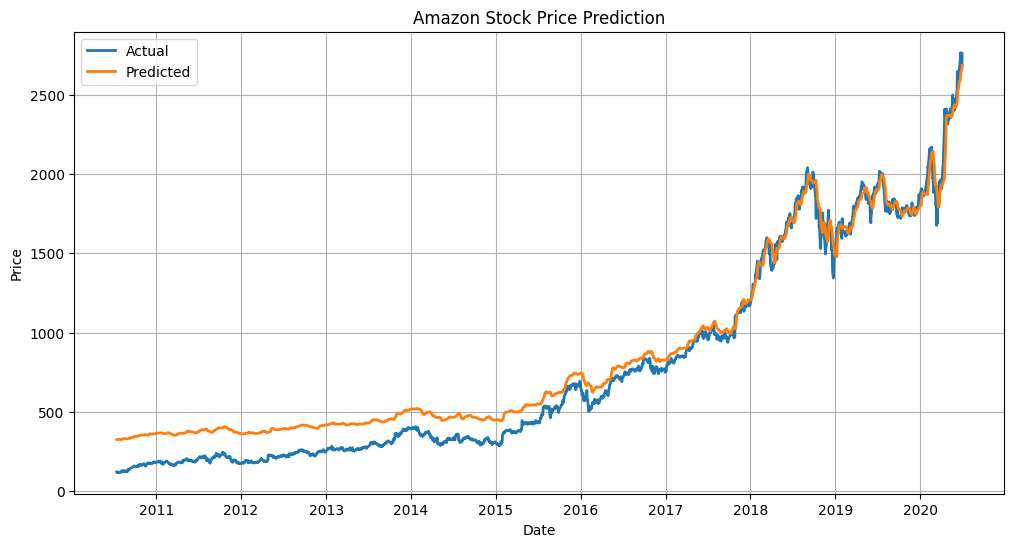

Mean Squared Error (MSE) for Amazon: 15153.78
Mean Absolute Error (MAE) for Amazon: 106.24
Root Mean Squared Error (RMSE) for Amazon: 123.10
R-squared (R2) for Amazon: 0.96
65/65 [==============================] - 0s 2ms/step


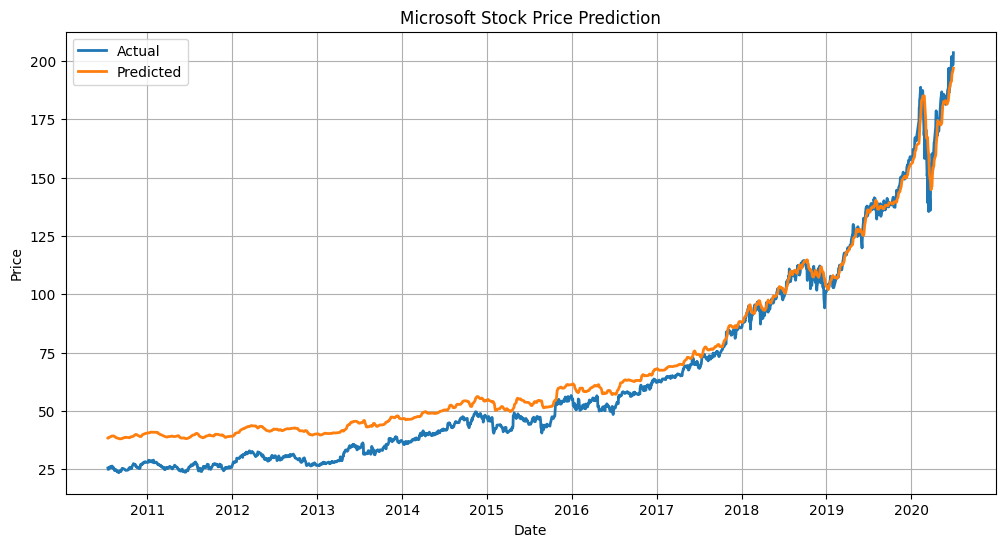

Mean Squared Error (MSE) for Microsoft: 75.73
Mean Absolute Error (MAE) for Microsoft: 7.48
Root Mean Squared Error (RMSE) for Microsoft: 8.70
R-squared (R2) for Microsoft: 0.96
65/65 [==============================] - 0s 2ms/step


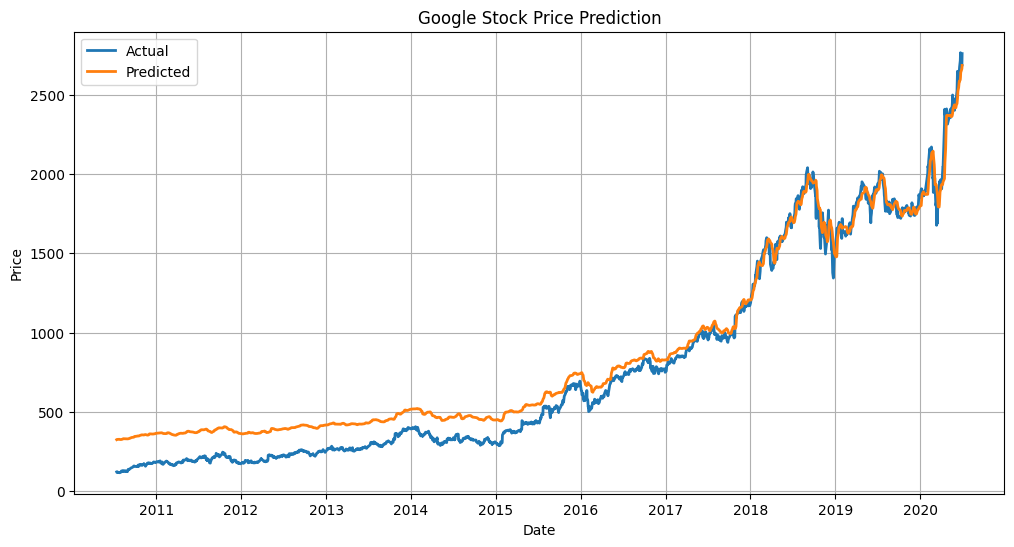

Mean Squared Error (MSE) for Google: 15153.78
Mean Absolute Error (MAE) for Google: 106.24
Root Mean Squared Error (RMSE) for Google: 123.10
R-squared (R2) for Google: 0.96
65/65 [==============================] - 0s 3ms/step


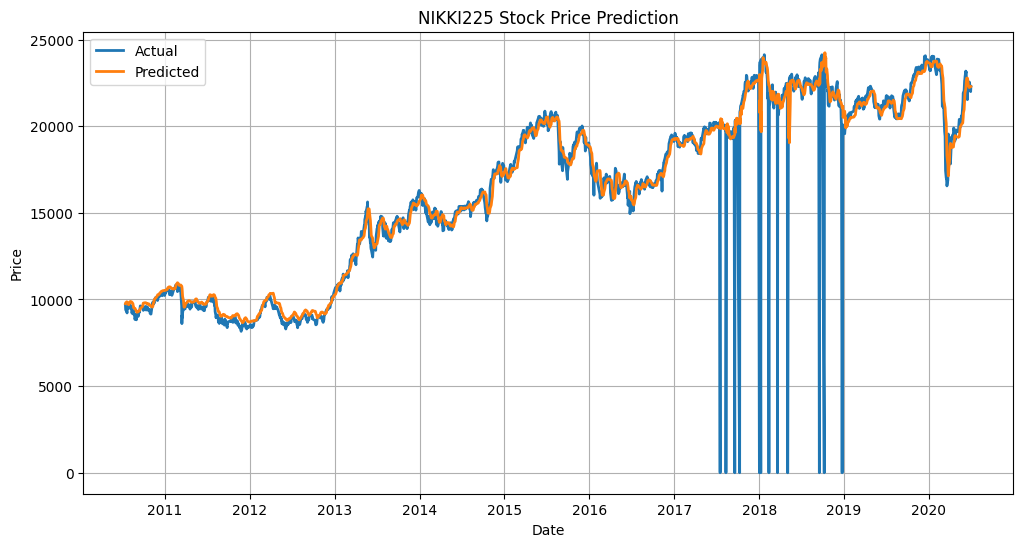

Mean Squared Error (MSE) for NIKKI225: 3383308.19
Mean Absolute Error (MAE) for NIKKI225: 503.76
Root Mean Squared Error (RMSE) for NIKKI225: 1839.38
R-squared (R2) for NIKKI225: 0.87
65/65 [==============================] - 0s 3ms/step


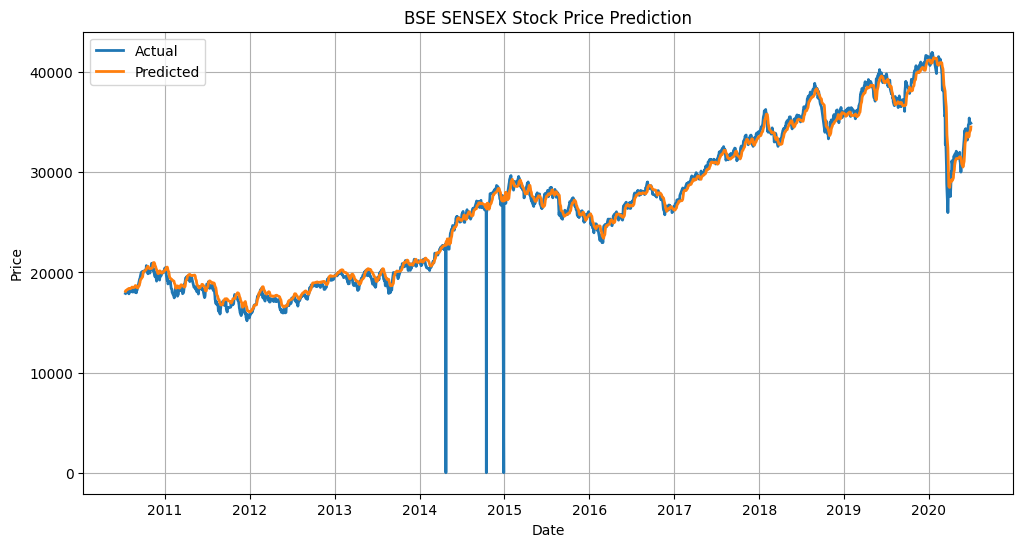

Mean Squared Error (MSE) for BSE SENSEX: 1387019.51
Mean Absolute Error (MAE) for BSE SENSEX: 517.80
Root Mean Squared Error (RMSE) for BSE SENSEX: 1177.72
R-squared (R2) for BSE SENSEX: 0.97
65/65 [==============================] - 0s 3ms/step


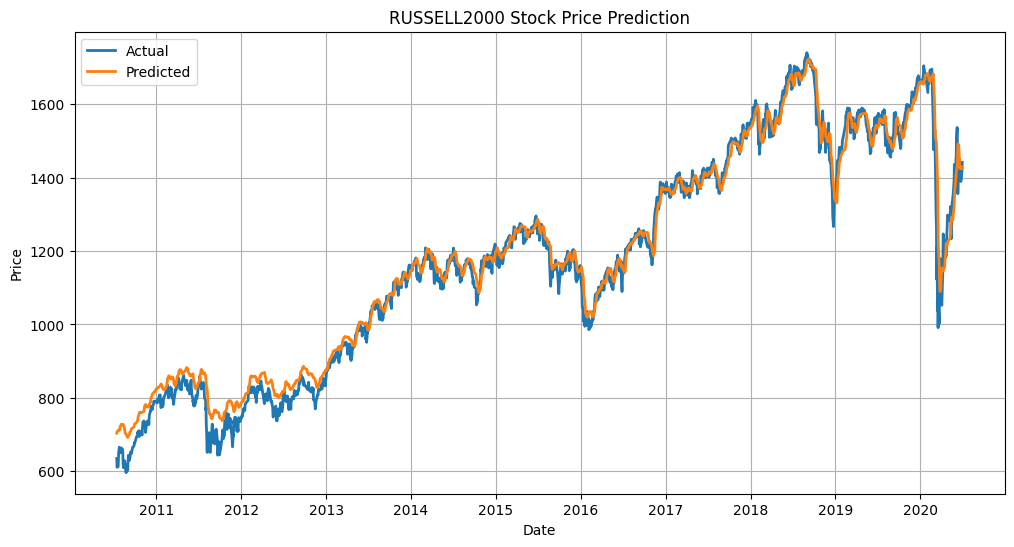

Mean Squared Error (MSE) for RUSSELL2000: 1562.24
Mean Absolute Error (MAE) for RUSSELL2000: 28.22
Root Mean Squared Error (RMSE) for RUSSELL2000: 39.53
R-squared (R2) for RUSSELL2000: 0.98
65/65 [==============================] - 0s 2ms/step


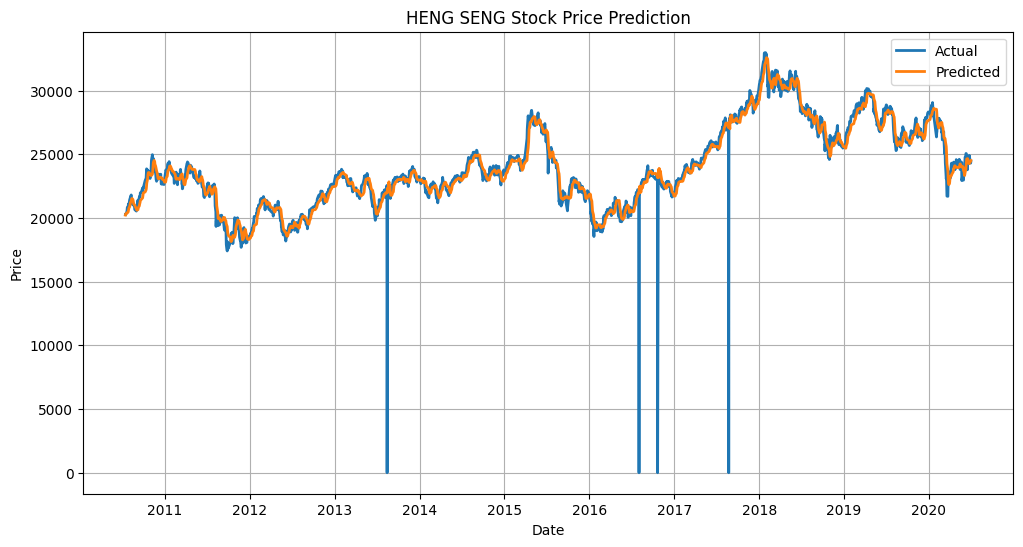

Mean Squared Error (MSE) for HENG SENG: 1401474.08
Mean Absolute Error (MAE) for HENG SENG: 488.83
Root Mean Squared Error (RMSE) for HENG SENG: 1183.84
R-squared (R2) for HENG SENG: 0.88
65/65 [==============================] - 0s 3ms/step


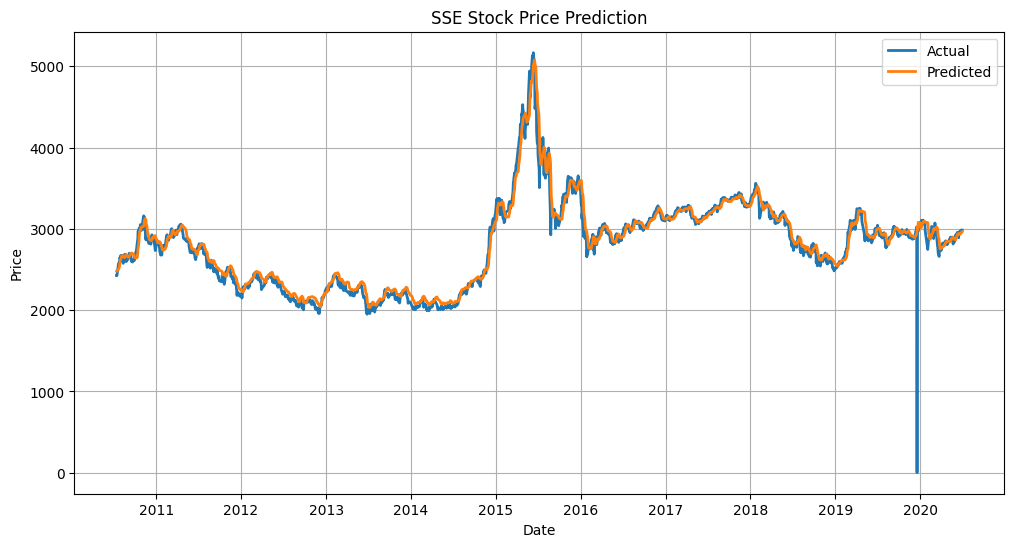

Mean Squared Error (MSE) for SSE: 13250.35
Mean Absolute Error (MAE) for SSE: 64.38
Root Mean Squared Error (RMSE) for SSE: 115.11
R-squared (R2) for SSE: 0.95
65/65 [==============================] - 0s 3ms/step


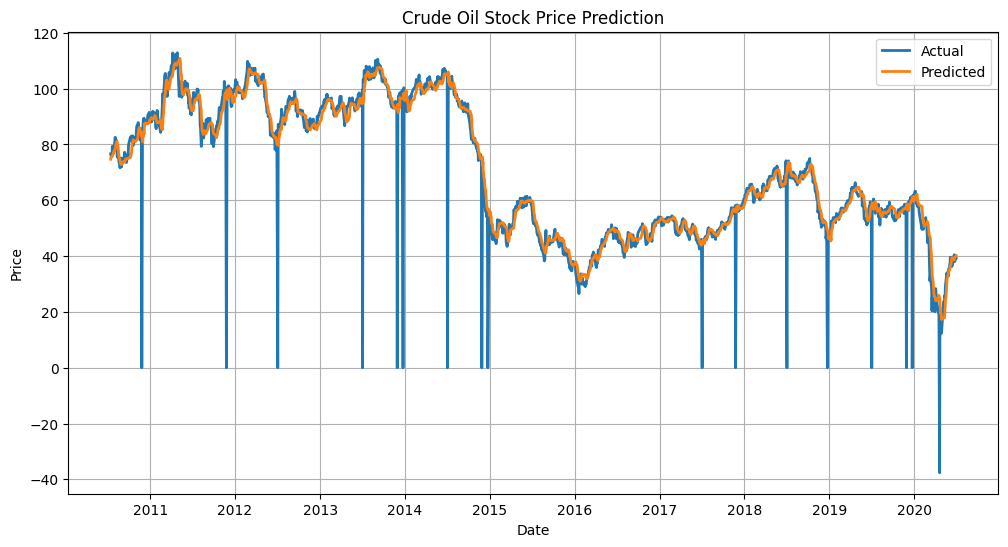

Mean Squared Error (MSE) for Crude Oil: 54.32
Mean Absolute Error (MAE) for Crude Oil: 2.70
Root Mean Squared Error (RMSE) for Crude Oil: 7.37
R-squared (R2) for Crude Oil: 0.91


In [23]:
# Load the dataset from Google Drive
# Replace 'your_google_drive_link' with the actual link to your CSV file
data = pd.read_csv('/content/sample_data/DATA.csv')

# Data Preprocessing
# Rename columns (ensure they match the columns in your training data)
data.columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'NASDAQ', 'NYSE', 'S&P 500', 'FTSE100', 'NIKKI225', 'BSE SENSEX', 'RUSSELL2000', 'HENG SENG', 'SSE', 'Crude Oil', 'Gold', 'VIX', 'USD index', 'Amazon', 'Google', 'Microsoft']

# Convert 'Date' column to datetime
data['Date'] = pd.to_datetime(data['Date'])

# Section 1: Data Cleaning - Remove Rows with NaN Values
data.dropna(inplace=True)

# Define a function to make predictions for a given asset
def predict_asset(asset_name):
    # Create a new MinMaxScaler for the asset data
    scaler = MinMaxScaler(feature_range=(0, 1))

    # Scale the asset data
    asset_data_scaled = scaler.fit_transform(data[[asset_name]])

    # Create sequences for the asset data
    x_asset = []
    y_asset = []

    for i in range(timesteps, len(asset_data_scaled)):
        x_asset.append(asset_data_scaled[i - timesteps:i, 0])
        y_asset.append(asset_data_scaled[i, 0])

    x_asset, y_asset = np.array(x_asset), np.array(y_asset)

    # Reshape input data
    x_asset = x_asset.reshape((x_asset.shape[0], x_asset.shape[1], 1))

    # Predict on the asset data
    asset_predictions = model.predict(x_asset)

    # Inverse transform the predictions to the original scale
    asset_predictions = scaler.inverse_transform(asset_predictions)

    return asset_predictions

# List of asset names you want to predict
asset_names = ['Gold', 'Amazon', 'Microsoft', 'Google', 'NIKKI225', 'BSE SENSEX', 'RUSSELL2000', 'HENG SENG', 'SSE', 'Crude Oil']  # Add more assets as needed

# Function to calculate and print evaluation metrics
def evaluate_predictions(actual, predicted):
    mse = mean_squared_error(actual, predicted)
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mse)
    r2 = r2_score(actual, predicted)

    print(f"Mean Squared Error (MSE) for {asset_name}: {mse:.2f}")
    print(f"Mean Absolute Error (MAE) for {asset_name}: {mae:.2f}")
    print(f"Root Mean Squared Error (RMSE) for {asset_name}: {rmse:.2f}")
    print(f"R-squared (R2) for {asset_name}: {r2:.2f}")

# Plot actual vs. predicted values for each asset
for asset_name in asset_names:
    asset_predictions = predict_asset(asset_name)
    dates = data['Date'][timesteps:]
    actual_data = data[asset_name][timesteps:]

    plt.figure(figsize=(12, 6))
    plt.plot(dates, actual_data, label='Actual', linewidth=2)
    plt.plot(dates, asset_predictions, label='Predicted', linewidth=2)
    plt.title(f'{asset_name} Stock Price Prediction')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Evaluate predictions for the asset
    evaluate_predictions(actual_data, asset_predictions)